In [13]:
#%pip install scikeras
#%pip install spectral
#%pip install scikit-optimize
#%pip install tensorflow

In [14]:
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scikeras.wrappers import KerasClassifier, KerasRegressor
from scipy.stats import reciprocal
from sklearn.metrics import accuracy_score
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_evaluations
import pandas as pd
import skopt
from sklearn.model_selection import train_test_split

sns.set(style="white")
plt.set_cmap('jet')

<Figure size 640x480 with 0 Axes>

# Load the Data

In [15]:
# Load the mineral spectral library 
lib = envi.open('./mineral_mapping_lib_20240314.hdr')
wl_lib = lib.bands.centers
nBands_lib = len(wl)
nClasses = len(lib.names)
print(f'Number of spectra: {nClasses}')
print(f'Number of wavelengths in spectral library: {nBands_lib}')

Number of spectra: 479
Number of wavelengths in spectral library: 88


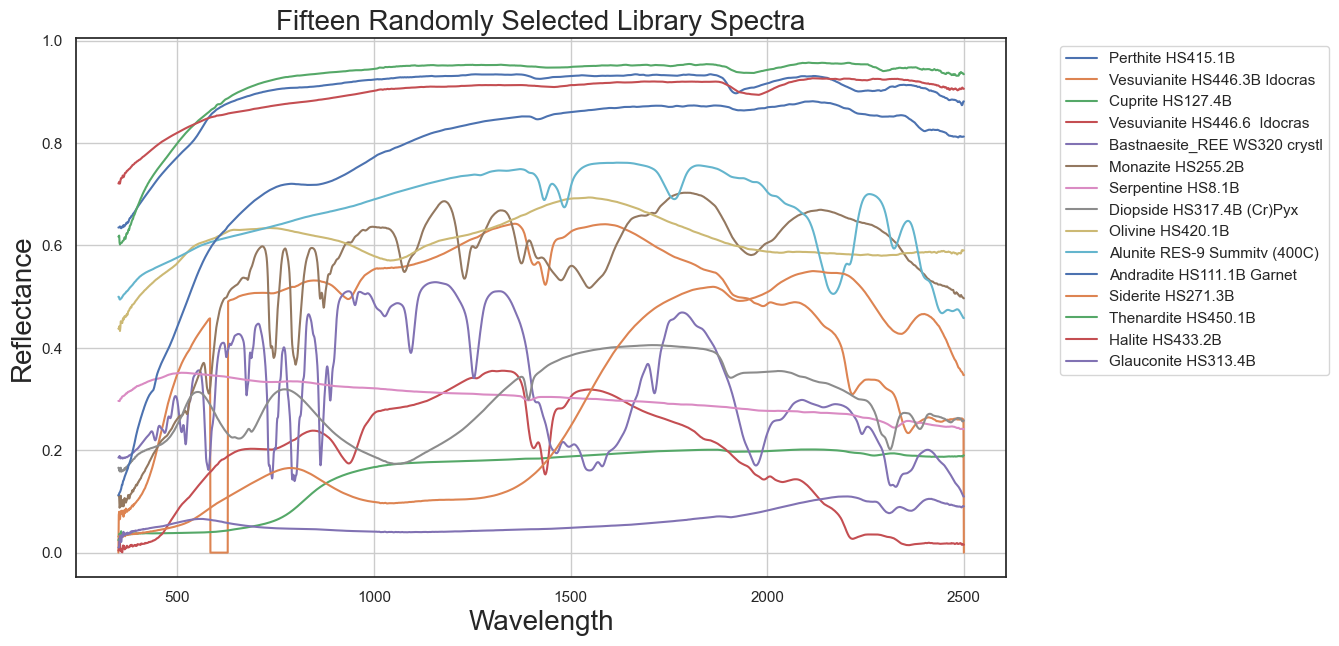

In [16]:
# Load and view a few spectra
plt.figure(figsize=(12,7))
plt.grid(True)
rnd_idx = np.random.randint(0,len(lib.names), 15)
for idx in rnd_idx:
    plt.plot(lib.bands.centers, lib.spectra[idx], label=lib.names[idx])
plt.xlabel('Wavelength', fontsize=20)
plt.ylabel('Reflectance', fontsize=20)
plt.title('Fifteen Randomly Selected Library Spectra', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [17]:
# Open the image
im = envi.open('./cuprite_AVIRIS_subset.hdr')
# Load the image as an array
im_arr = im.load()
nRows, nCols, nBands = im_arr.shape
wl = im.bands.centers
print(f'Number of Rows: {nRows}')
print(f'Number of Columns: {nCols}')
print(f'Number of Bands: {nBands}')

Number of Rows: 501
Number of Columns: 501
Number of Bands: 88


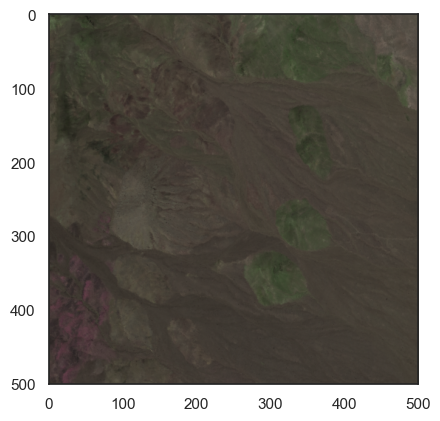

In [18]:
# View the image
plt.imshow(im_arr[:,:,[30,60,80]]);

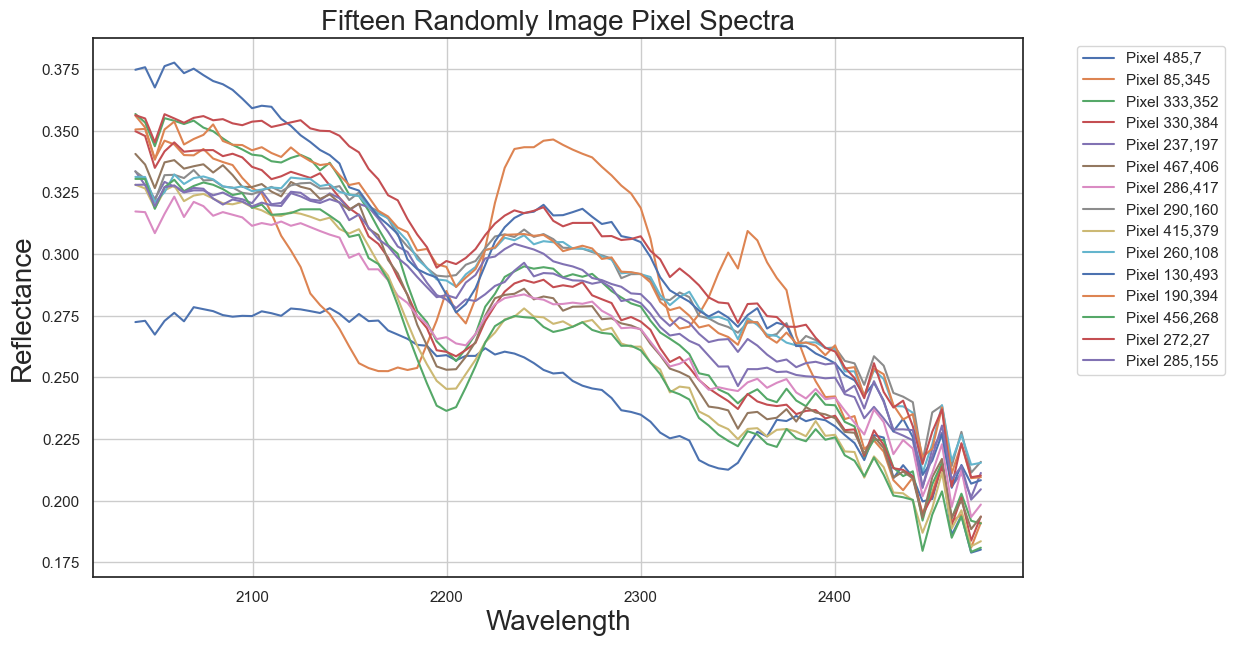

In [19]:
# Load and view a few spectra from the image
plt.figure(figsize=(12,7))
plt.grid(True)
rnd_x = np.random.randint(0,nRows, 15)
rnd_y = np.random.randint(0,nCols, 15)
for x,y in zip(rnd_x,rnd_y):
    plt.plot(im.bands.centers, im_arr[x,y,:].flatten(), label=f'Pixel {x},{y}')
plt.xlabel('Wavelength', fontsize=20)
plt.ylabel('Reflectance', fontsize=20)
plt.title('Fifteen Randomly Image Pixel Spectra', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [21]:
resampler = BandResampler(lib.bands, im.bands)
spectra = resampler(lib.spectra.T).T
lib.spectra = spectra
lib.bands.centers = wl
print(f'Number of spectra: {spectra.shape[0]}')
print(f'Number of wavelengths in spectral library: {len(wl)}')

Number of spectra: 479
Number of wavelengths in spectral library: 88


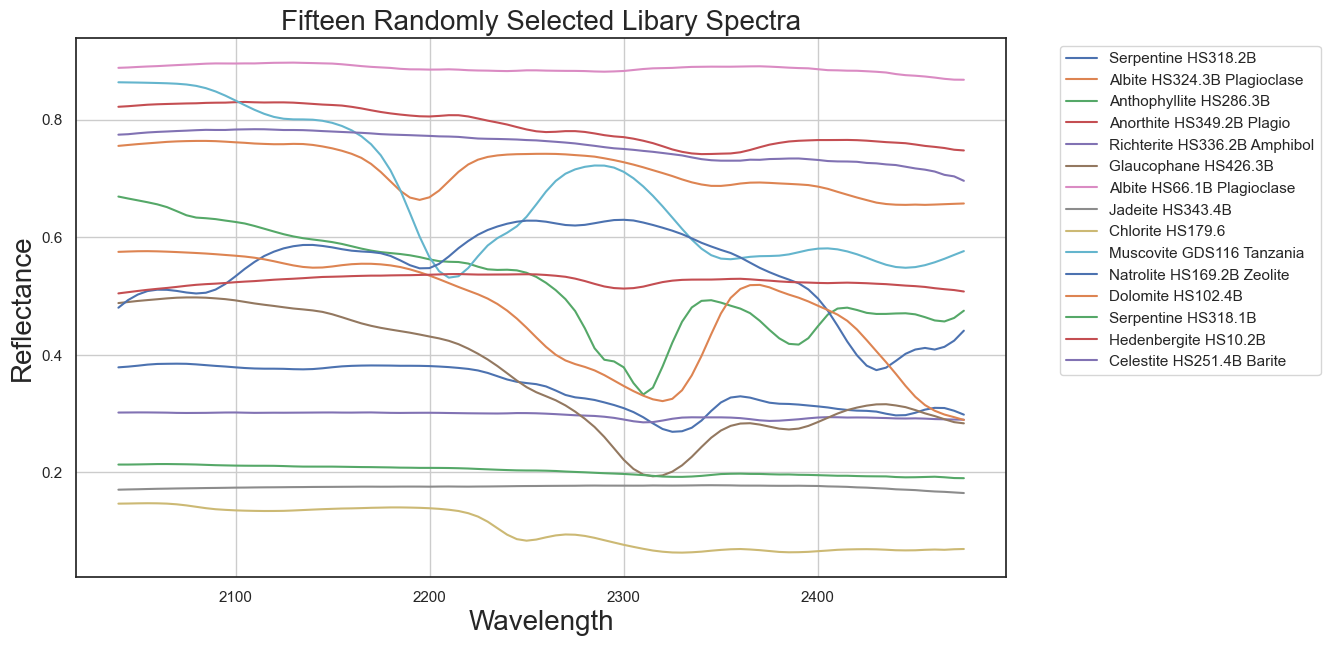

In [23]:
# Load and view a few spectra
plt.figure(figsize=(12,7))
plt.grid(True)
rnd_idx = np.random.randint(0,len(lib.names), 15)
for idx in rnd_idx:
    plt.plot(wl, spectra[idx], label=lib.names[idx])
plt.xlabel('Wavelength', fontsize=20)
plt.ylabel('Reflectance', fontsize=20)
plt.title('Fifteen Randomly Selected Libary Spectra', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');
plt.savefig('RandomSpectra')

# Build a NN to do (1) identify pixel spectra from the image and (2) do unmixing on the iamge